In [184]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rv_continuous

In [188]:
np.random.seed(42)

# mixed device is good for bloch sphere plots
dev = qml.device('default.mixed', wires=1)

class sin_prob_dist(rv_continuous):
    def _pdf(self, theta):
        return 0.5 * np.sin(theta)
    
# Some unknown distribution
class cos_prob_dist(rv_continuous):
    def _pdf(self, theta):
        return 0.5 * np.cos(theta)
    
# Samples drawn from between 0 and pi
sin_sampler = sin_prob_dist(a=0, b=np.pi)
dist_sampler = cos_prob_dist(a=0, b=np.pi)

@qml.qnode(dev)
def haar_random_unitary():
    phi, omega = 2 * np.pi * np.random.uniform(size=2)
    theta = sin_sampler.rvs()
    qml.Rot(phi, theta, omega, wires=0)
    return qml.state()

@qml.qnode(dev)
def dist_random_unitary():
    phi, omega = 2 * np.pi * np.random.uniform(size=2)
    theta = dist_sampler.rvs()
    qml.Rot(phi, theta, omega, wires=0)
    return qml.state()

num_samples = 1000
haar_samples = [dist_random_unitary() for _ in range(num_samples)]

X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def convert_to_bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    return [ax, ay, az]

distribution_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in haar_samples])

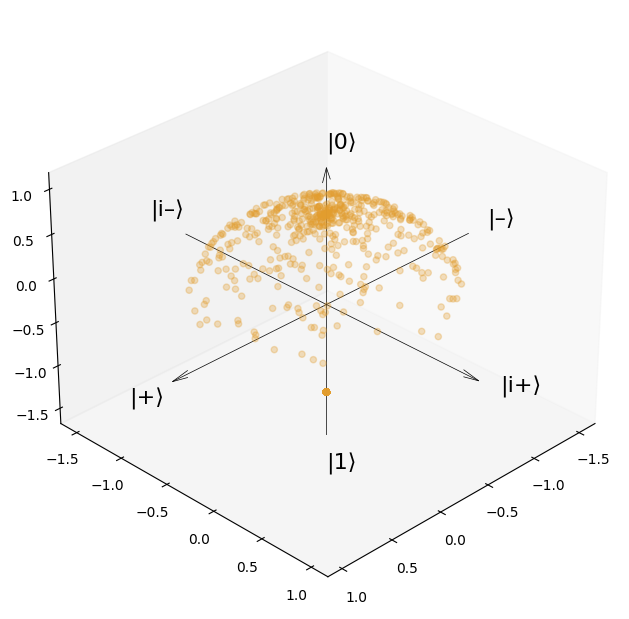

In [189]:
def plot_bloch_sphere(bloch_vectors):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    ax.grid(False)
    # ax.set_axis_off()
    ax.view_init(30, 45)
    ax.dist = 7

    x, y, z = np.array([[-1.5,0,0], [0, -1.5, 0], [0, 0, -1.5]])
    u, v, w = np.array([[3,0,0], [0, 3, 0], [0,0,3]])
    ax.quiver(x, y, z, u, v, w, arrow_length_ratio=0.05, color="black", linewidth=0.5)

    ax.text(0, 0, 1.7, r"|0⟩", color="black", fontsize=16)
    ax.text(0, 0, -1.9, r"|1⟩", color="black", fontsize=16)
    ax.text(1.9, 0, 0, r"|+⟩", color="black", fontsize=16)
    ax.text(-1.7, 0, 0, r"|–⟩", color="black", fontsize=16)
    ax.text(0, 1.7, 0, r"|i+⟩", color="black", fontsize=16)
    ax.text(0,-1.9, 0, r"|i–⟩", color="black", fontsize=16)

    ax.scatter(bloch_vectors[:, 0], bloch_vectors[:, 1], bloch_vectors[:, 2], c="#e29d2e", alpha=0.3)
    
plot_bloch_sphere(distribution_bloch_vectors)

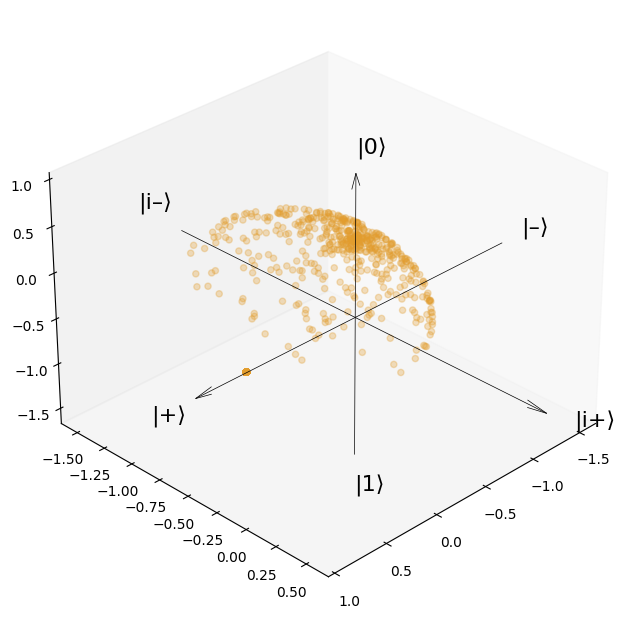

In [202]:
# Random unitaries to scramble the sampled states
# TODO: Add seed for recreatibility
def generate_random_unitary(num_qubits, t=5):
    return [qml.math.linalg.expm(1j * np.random.randn(2 ** num_qubits, 2 ** num_qubits)) for _ in range(t)]

num_qubits = 1
t = 1
random_unitaries = generate_random_unitary(num_qubits, t)

def forward_scrambling(states, unitaries):
    scrambled_states = []
    for state in states:
        for U in unitaries:
            state = U @ state
        scrambled_states.append(state)
    return np.array(scrambled_states)

# qml.QubitUnitary(random_unitaries, 1)

# input_state = np.array([1, 0]) # Dummy test |0>
# phis = np.random.uniform(0, 2 * np.pi, 3 * 2) # random rotation angles
# final_state = forward_scrambling(input_state, phis, t)
# print(final_state)

# scrambled_states = [forward_scrambling(s, phis, t) for s in haar_samples]

scrambled_states = forward_scrambling(haar_samples, random_unitaries)
scrambled_bloch_states = np.array([convert_to_bloch_vector(s) for s in scrambled_states])
plot_bloch_sphere(scrambled_bloch_states)

[[[-3.39178756e-17+4.74056583e-17j -7.63504884e-01+5.68562873e-01j]
  [ 1.46718377e-17+1.16798081e-17j  1.70083104e-01+2.54692538e-01j]]

 [[ 2.46076696e-01+6.77874513e-01j  1.12006210e-01+2.76809307e-02j]
  [-4.53179030e-01+4.99603864e-01j  2.60269401e-02+1.04728807e-01j]]

 [[-3.41705654e-17-3.55310207e-17j  6.02891403e-02-8.02801723e-01j]
  [-2.80839539e-17-2.30349738e-17j -2.55040997e-02-5.92641674e-01j]]

 ...

 [[ 6.77357654e-01+2.67235665e-01j -3.58552702e-01-1.60059371e-02j]
  [ 4.35461078e-01-2.91009081e-01j -1.56335458e-01+2.05431413e-01j]]

 [[-1.34086490e-02-7.04993485e-01j  8.37616096e-02-7.70121753e-02j]
  [ 5.49330644e-01+4.19119654e-01j  8.09639286e-03+1.11204853e-01j]]

 [[ 3.68111538e-17-2.83116188e-17j -5.97476815e-01-4.67128729e-01j]
  [-3.87455291e-17+9.56946328e-18j  3.08897177e-01+5.73929212e-01j]]]


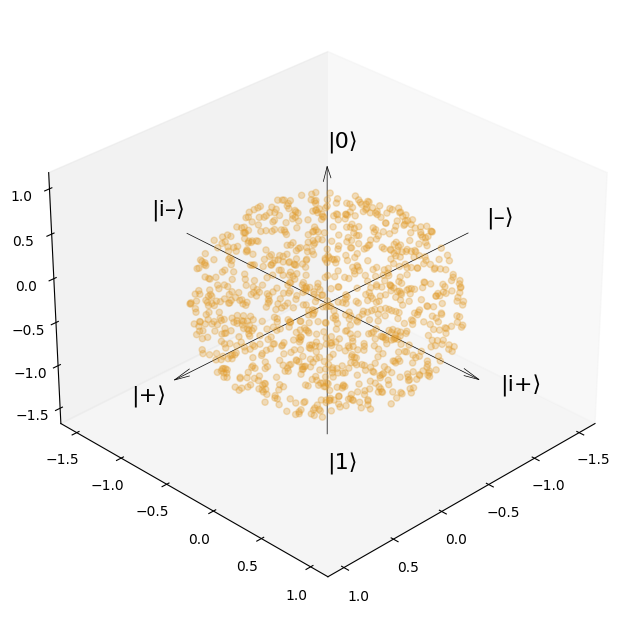

In [208]:
from scipy.stats import unitary_group

seed = 42

def haar_random_unitary(seed=None):
    np.random.seed(seed)
    return unitary_group.rvs(2)

def scramble_state_vectors(state_vectors, seed):
    scrambled_vectors = []

    for i in range(num_samples):
        U = haar_random_unitary(seed)
        
        scrambled_state = np.dot(U, state_vectors[i])
        scrambled_state /= np.linalg.norm(scrambled_state)
        scrambled_vectors.append(scrambled_state)

        seed += 1

    return np.array(scrambled_vectors)

scrambled_states = scramble_state_vectors(np.array(haar_samples), seed)
scrambled_bloch_states = np.array([convert_to_bloch_vector(s) for s in scrambled_states])
plot_bloch_sphere(scrambled_bloch_states)
print(scrambled_states)
